## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

import seaborn as sns
import os

from sklearn import preprocessing

## Data Loading

In [2]:
df_order = pd.read_excel('./Rec_sys_data.xlsx', 'order')
df_customer = pd.read_excel('./Rec_sys_data.xlsx', 'customer')
df_product = pd.read_excel('./Rec_sys_data.xlsx', 'product')

In [3]:
df_order.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,DeliveryDate,Discount%,ShipMode,ShippingCost,CustomerID
0,536365,84029E,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.20,ExpressAir,30.12,17850
1,536365,71053,6,2010-12-01 08:26:00,2010-12-02 08:26:00,0.21,ExpressAir,30.12,17850
2,536365,21730,6,2010-12-01 08:26:00,2010-12-03 08:26:00,0.56,Regular Air,15.22,17850
3,536365,84406B,8,2010-12-01 08:26:00,2010-12-03 08:26:00,0.30,Regular Air,15.22,17850
4,536365,22752,2,2010-12-01 08:26:00,2010-12-04 08:26:00,0.57,Delivery Truck,5.81,17850


In [4]:
df_customer.head()

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment
0,13089,male,53,High,8625,Small Business
1,15810,female,22,Low,87797,Small Business
2,15556,female,29,High,29257,Corporate
3,13137,male,29,Medium,97818,Middle class
4,16241,male,36,Low,79200,Small Business


In [5]:
df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


In [6]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        4372 non-null   int64 
 1   Gender            4372 non-null   object
 2   Age               4372 non-null   int64 
 3   Income            4372 non-null   object
 4   Zipcode           4372 non-null   int64 
 5   Customer Segment  4372 non-null   object
dtypes: int64(3), object(3)
memory usage: 205.1+ KB


In [7]:
df_customer.describe()

,CustomerID,Age,Zipcode
count,4372.000000,4372.000000,4372.000000
mean,15299.677722,36.482388,50197.537511
std,1722.390705,10.888042,28724.484607
min,12346.000000,18.000000,7.000000
25%,13812.750000,27.000000,25851.500000
50%,15300.500000,36.000000,50297.000000
75%,16778.250000,46.000000,74774.500000
max,18287.000000,55.000000,99938.000000


## Pre Processing

In [8]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

### Check Missing Values

In [9]:
missing_zero_values_table(df_customer)

Your selected dataframe has 6 columns and 4372 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


# EDA

### Age Distribution

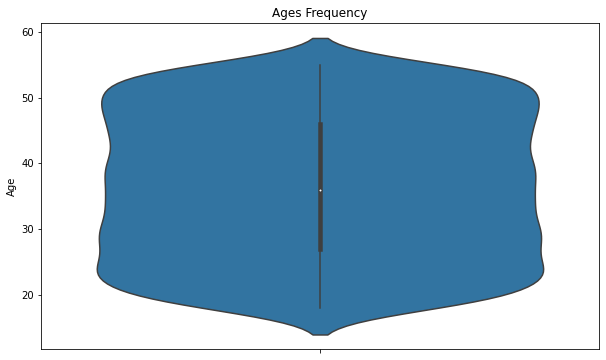

In [10]:
plt.figure(figsize=(10,6))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=df_customer["Age"])
plt.show()

### Gender Distribution

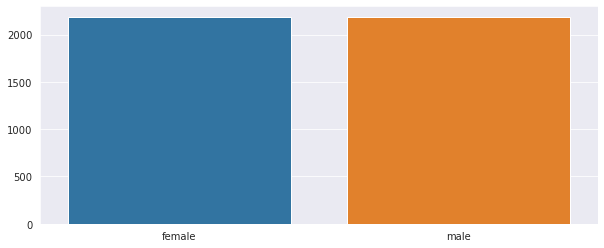

In [11]:
genders = df_customer.Gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

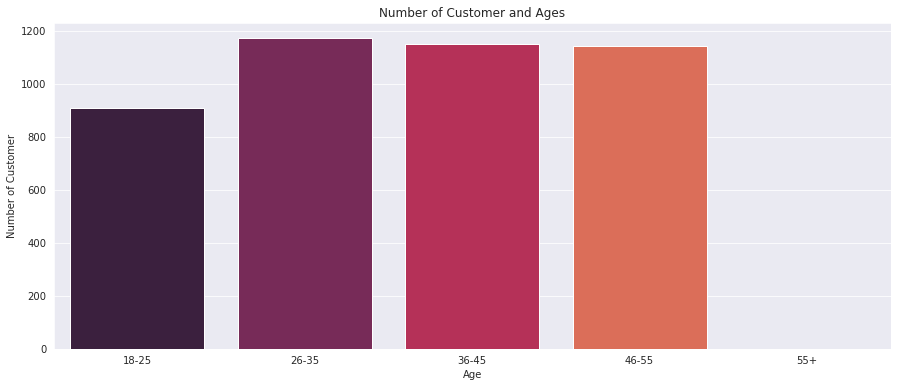

In [12]:

age18_25 = df_customer.Age[(df_customer.Age <= 25) & (df_customer.Age >= 18)]
age26_35 = df_customer.Age[(df_customer.Age <= 35) & (df_customer.Age >= 26)]
age36_45 = df_customer.Age[(df_customer.Age <= 45) & (df_customer.Age >= 36)]
age46_55 = df_customer.Age[(df_customer.Age <= 55) & (df_customer.Age >= 46)]
age55above = df_customer.Age[df_customer.Age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

### Label Encoding

In [13]:
# label_encoder object knows how to understand word labels.
gender_encoder = preprocessing.LabelEncoder()
segment_encoder = preprocessing.LabelEncoder()
income_encoder =  preprocessing.LabelEncoder()
    
# Encode labels in column 
df_customer['age'] = df_customer.Age
df_customer['gender']= gender_encoder.fit_transform(df_customer['Gender'])
df_customer['customer_segment']= segment_encoder.fit_transform(df_customer['Customer Segment'])
df_customer['income_segment']= income_encoder.fit_transform(df_customer['Income'])

 
print("gender_encoder",df_customer['gender'].unique())
print("segment_encoder",df_customer['customer_segment'].unique())
print("income_encoder",df_customer['income_segment'].unique())

gender_encoder [1 0]
segment_encoder [2 0 1]
income_encoder [0 1 2]


In [14]:
df_customer.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment',
       'age', 'gender', 'customer_segment', 'income_segment'],
      dtype='object')

In [15]:
df_customer.iloc[:,6:]

,age,gender,customer_segment,income_segment
0,53,1,2,0
1,22,0,2,1
2,29,0,0,0
3,29,1,1,2
4,36,1,2,1
...,...,...,...,...
4367,22,0,0,0
4368,23,1,1,0
4369,40,1,1,2
4370,37,1,1,2


## ELBOW - Kmeans - customer demographics

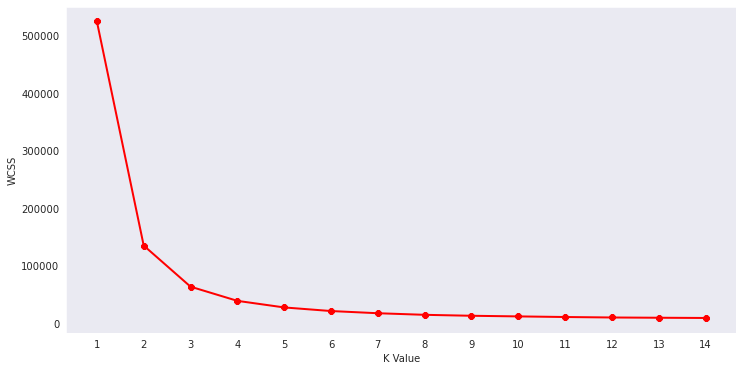

In [16]:
### Heading Required

wcss = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_customer.iloc[:,6:])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,15,1))
plt.ylabel("WCSS")
plt.show()

## Hierarchical Clustering Dendrogram

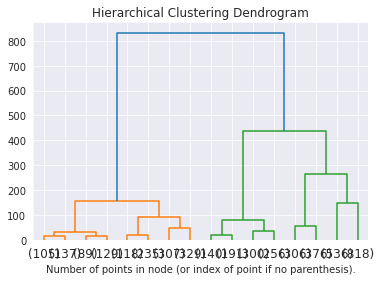

In [17]:
#function to plot dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_customer.iloc[:,6:])

plt.title("Hierarchical Clustering Dendrogram")

# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Perform Kmeans

In [18]:
# Perfomr kmeans

km = KMeans(n_clusters=15)
clusters = km.fit_predict(df_customer.iloc[:,6:])

# saving prediction back to raw dataset
df_customer['cluster'] = clusters

In [19]:
df_customer.iloc[:,6:]

,age,gender,customer_segment,income_segment,cluster
0,53,1,2,0,10
1,22,0,2,1,1
2,29,0,0,0,3
3,29,1,1,2,3
4,36,1,2,1,5
...,...,...,...,...,...
4367,22,0,0,0,1
4368,23,1,1,0,1
4369,40,1,1,2,0
4370,37,1,1,2,8


In [20]:
df_customer

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,age,gender,customer_segment,income_segment,cluster
0,13089,male,53,High,8625,Small Business,53,1,2,0,10
1,15810,female,22,Low,87797,Small Business,22,0,2,1,1
2,15556,female,29,High,29257,Corporate,29,0,0,0,3
3,13137,male,29,Medium,97818,Middle class,29,1,1,2,3
4,16241,male,36,Low,79200,Small Business,36,1,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...
4367,17763,female,22,High,57980,Corporate,22,0,0,0,1
4368,16078,male,23,High,38622,Middle class,23,1,1,0,1
4369,13270,male,40,Medium,57985,Middle class,40,1,1,2,0
4370,15562,male,37,Medium,91274,Middle class,37,1,1,2,8


In [21]:
df_customer.columns

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment',
       'age', 'gender', 'customer_segment', 'income_segment', 'cluster'],
      dtype='object')

In [22]:
df_customer = df_customer[['CustomerID', 'Gender', 'Age', 'Income', 'Zipcode', 'Customer Segment', 'cluster']]

In [23]:
df_customer

,CustomerID,Gender,Age,Income,Zipcode,Customer Segment,cluster
0,13089,male,53,High,8625,Small Business,10
1,15810,female,22,Low,87797,Small Business,1
2,15556,female,29,High,29257,Corporate,3
3,13137,male,29,Medium,97818,Middle class,3
4,16241,male,36,Low,79200,Small Business,5
...,...,...,...,...,...,...,...
4367,17763,female,22,High,57980,Corporate,1
4368,16078,male,23,High,38622,Middle class,1
4369,13270,male,40,Medium,57985,Middle class,0
4370,15562,male,37,Medium,91274,Middle class,8


In [24]:
df_customer.cluster.unique()

array([10,  1,  3,  5,  7,  4,  8,  2, 13, 12,  9,  0,  6, 14, 11],
      dtype=int32)

## EDA - Cluster Level

In [25]:
def plotting_percentages(df, col, target):
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    order_list = list(df[col].unique())
    order_list.sort()

    # Plot the figure
    sns.set(font_scale=1.5)
    g = sns.catplot(x=x, y='percent', hue=y,kind='bar', data=temp_df, 
                    height=8, aspect=2, order=order_list, legend_out=False)
    g.ax.set_ylim(0,100)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        
    # Set labels and title
    plt.title(f'{col.title()} By Percent {target.title()}', 
              fontdict={'fontsize': 30})
    plt.xlabel(f'{col.title()}', fontdict={'fontsize': 20})
    plt.ylabel(f'{target.title()} Percentage', fontdict={'fontsize': 20})
    plt.xticks(rotation=75)
    return g

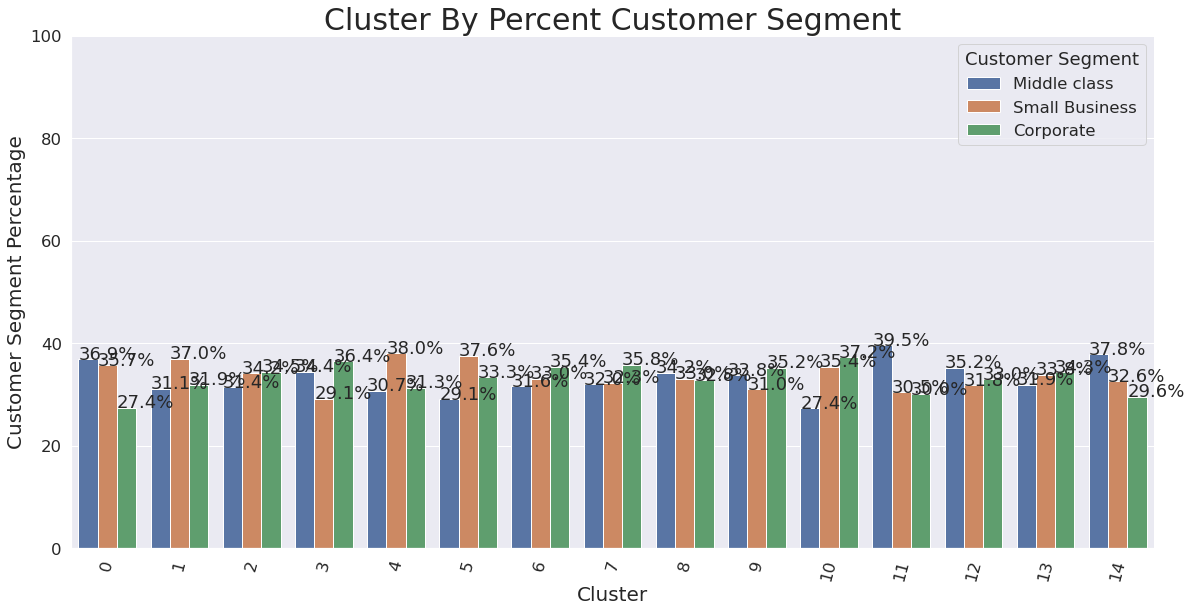

In [26]:
plotting_percentages(df_customer, 'cluster', 'Customer Segment')

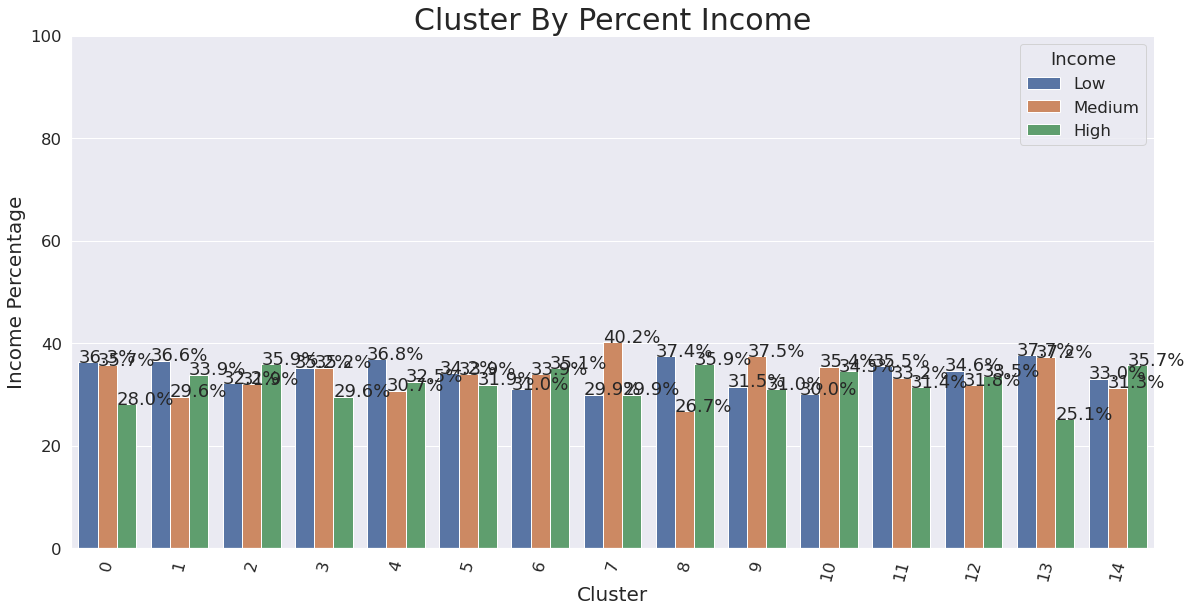

In [27]:
plotting_percentages(df_customer, 'cluster', 'Income')

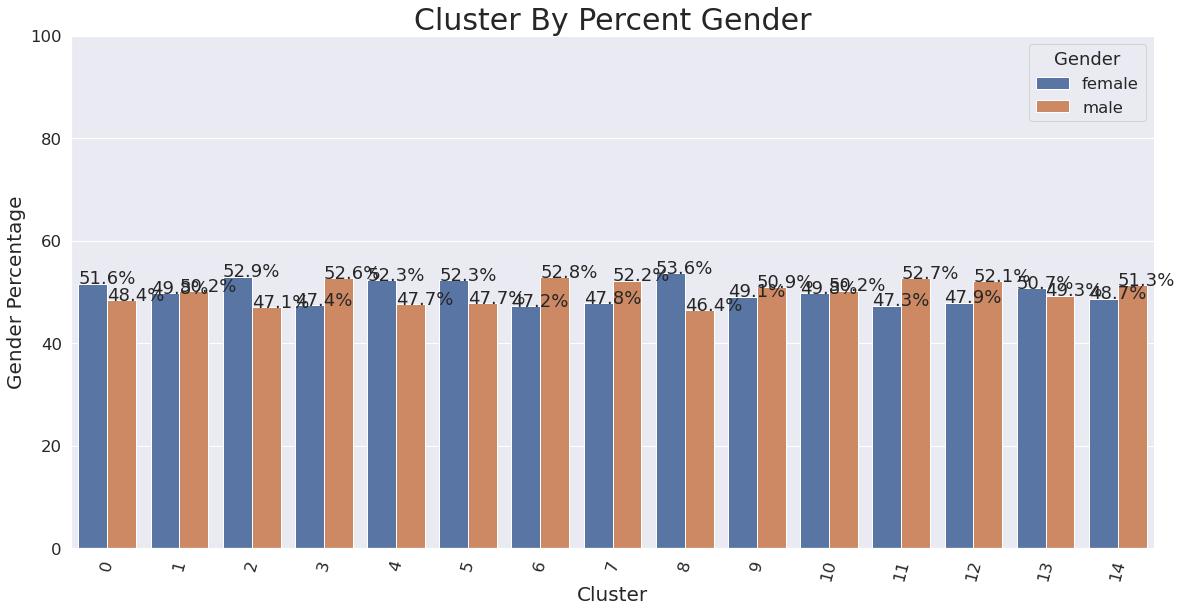

In [28]:
plotting_percentages(df_customer, 'cluster', 'Gender')

## Avg Age per Cluster

<AxesSubplot:xlabel='cluster'>

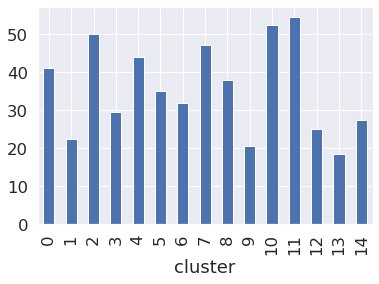

In [29]:
df_customer.groupby('cluster').Age.mean().plot(kind='bar')

In [30]:
df_order.shape

(272404, 9)

In [31]:
order_cluster_mapping = pd.merge(df_order,df_customer, on='CustomerID', how='inner')[['StockCode','CustomerID','cluster']]


In [32]:
order_cluster_mapping

,StockCode,CustomerID,cluster
0,84029E,17850,7
1,71053,17850,7
2,21730,17850,7
3,84406B,17850,7
4,22752,17850,7
...,...,...,...
272399,21818,17666,0
272400,21817,17666,0
272401,23329,17666,0
272402,71459,17666,0


## Generate ScoreDF

In [33]:
score_df = order_cluster_mapping.groupby(['cluster','StockCode']).count().reset_index()

In [34]:
score_df

,cluster,StockCode,CustomerID
0,0,10002,3
1,0,10080,2
2,0,10125,2
3,0,10133,7
4,0,10135,9
...,...,...,...
36811,14,BANK CHARGES,1
36812,14,C2,4
36813,14,M,8
36814,14,PADS,1


In [35]:
score_df = score_df.rename(columns={'CustomerID':'Score'})

In [36]:
score_df

,cluster,StockCode,Score
0,0,10002,3
1,0,10080,2
2,0,10125,2
3,0,10133,7
4,0,10135,9
...,...,...,...
36811,14,BANK CHARGES,1
36812,14,C2,4
36813,14,M,8
36814,14,PADS,1


In [37]:
order_cluster_mapping

,StockCode,CustomerID,cluster
0,84029E,17850,7
1,71053,17850,7
2,21730,17850,7
3,84406B,17850,7
4,22752,17850,7
...,...,...,...
272399,21818,17666,0
272400,21817,17666,0
272401,23329,17666,0
272402,71459,17666,0


### Check for a customer

In [38]:
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'].unique()

array(['84029E', 71053, 21730, '84406B', 22752, '85123A', '84029G', 22633,
       22632, 20679, 21068, 21871, 82483, 21071, 82486, 37370, '82494L',
       82482, '15056BL', 22803, 22411], dtype=object)

In [39]:
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['cluster'].iloc[0]

7

In [40]:
order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'].value_counts()

84029G     17
84029E     17
21730      17
22632      17
22633      17
71053      17
85123A     17
22752      16
82483      15
21071      15
37370      15
21068      15
82482      15
82494L     15
84406B     15
21871      14
82486      14
22411      10
22803       8
20679       7
15056BL     4
Name: StockCode, dtype: int64

In [41]:
cluster_score_df = score_df[score_df.cluster==order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['cluster'].iloc[0]]

In [42]:
len(cluster_score_df.StockCode.unique())

2642

In [43]:
cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[(order_cluster_mapping.CustomerID == 17850)]['StockCode'])]

,cluster,StockCode,Score
17582,7,10002,5
17583,7,10080,1
17584,7,10120,2
17585,7,10125,5
17586,7,10133,13
...,...,...,...
20219,7,90210C,1
20220,7,90210D,1
20221,7,C2,1
20222,7,M,9


In [44]:
len(cluster_score_df.StockCode.unique())-len(order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'].unique())

2621

In [45]:
cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[order_cluster_mapping.CustomerID == 17850]['StockCode'])].nlargest(5, 'Score')

,cluster,StockCode,Score
19556,7,47566,108
18551,7,22423,95
20119,7,85099B,91
18821,7,22720,90
19692,7,84879,89


# Clustering on Product Description 

In [46]:
df_product.columns

Index(['StockCode', 'Product Name', 'Description', 'Category', 'Brand',
       'Unit Price'],
      dtype='object')

In [47]:
df_product.head()

,StockCode,Product Name,Description,Category,Brand,Unit Price
0,22629,Ganma Superheroes Ordinary Life Case For Samsu...,"New unique design, great gift.High quality pla...",Cell Phones|Cellphone Accessories|Cases & Prot...,Ganma,13.99
1,21238,Eye Buy Express Prescription Glasses Mens Wome...,Rounded rectangular cat-eye reading glasses. T...,Health|Home Health Care|Daily Living Aids,Eye Buy Express,19.22
2,22181,MightySkins Skin Decal Wrap Compatible with Ni...,Each Nintendo 2DS kit is printed with super-hi...,Video Games|Video Game Accessories|Accessories...,Mightyskins,14.99
3,84879,Mediven Sheer and Soft 15-20 mmHg Thigh w/ Lac...,The sheerest compression stocking in its class...,Health|Medicine Cabinet|Braces & Supports,Medi,62.38
4,84836,Stupell Industries Chevron Initial Wall D cor,Features: -Made in the USA. -Sawtooth hanger o...,Home Improvement|Paint|Wall Decals|All Wall De...,Stupell Industries,35.99


In [48]:
missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 29912 Rows.
There are 6 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
StockCode,0,25954,86.8,25954,86.8,object
Product Name,0,25954,86.8,25954,86.8,object
Description,0,25954,86.8,25954,86.8,object
Brand,0,1129,3.8,1129,3.8,object
Category,0,792,2.6,792,2.6,object
Unit Price,0,118,0.4,118,0.4,float64


In [49]:
df_product = df_product.dropna()

In [50]:
missing_zero_values_table(df_product)

Your selected dataframe has 6 columns and 3706 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [51]:
# 3. Pre-processing step: remove words like we'll, you'll, they'll etc.
df_product['Description'] = df_product['Description'].replace({"'ll": " "}, regex=True)

In [52]:
df_product['Description'] = df_product['Description'].replace({"-": " "}, regex=True)

In [53]:
df_product['Description'] = df_product['Description'].replace({"[^A-Za-z0-9 ]+": ""}, regex=True)

In [54]:
# Create word vectors from combined frames
# Make sure to make necessary imports

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

#converting text to features

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_product['Description'])

## Perform kmeans on Description

In [ ]:
#clustering your products based on text

km_des = KMeans(n_clusters=15,init='k-means++')
clusters = km_des.fit_predict(X)

df_product['cluster'] = clusters

In [ ]:
df_product

## Calucate cosine score

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import pandas as pd

def cosine_similarity_T(df,query):

    vec = TfidfVectorizer(analyzer='word', stop_words=ENGLISH_STOP_WORDS)
    vec_train = vec.fit_transform(df.Description)
    vec_query = vec.transform([query])
    
    within_cosine_similarity = []

    for i in range(len(vec_train.todense())):
        within_cosine_similarity.append(cosine_similarity(vec_train[i,:].toarray(), vec_query.toarray())[0][0])


    df['Similarity'] = within_cosine_similarity
    
    return df

In [ ]:
def recommend_product(customer_id):
    
    cluster_score_df = score_df[score_df.cluster==order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]['cluster'].iloc[0]]
    
    top_5_non_bought = cluster_score_df[~cluster_score_df.StockCode.isin(order_cluster_mapping[order_cluster_mapping.CustomerID == customer_id]['StockCode'])].nlargest(5, 'Score')
    print('\n--- top 5 StockCode - Non bought --------\n')
    print(top_5_non_bought)

    print('\n-------Recommendations Non bought ------\n')
    print(df_product[df_product.StockCode.isin(top_5_non_bought.StockCode)]['Product Name'])
    
    
    cust_orders = df_order[df_order.CustomerID == customer_id][['CustomerID','StockCode']]
        
    top_orders = cust_orders.groupby(['StockCode']).count().reset_index()
    top_orders = top_orders.rename(columns = {'CustomerID':'Counts'})
    top_orders['CustomerID'] = customer_id
    
    top_5_bought = top_orders.nlargest(5,'Counts')
    
    
    print('\n--- top 5 StockCode - bought --------\n')
    
    print(top_5_bought)
    
    print('\n-------Stock code Product (Bought) - Description cluster Mapping------\n')
    top_clusters = df_product[df_product.StockCode.isin(top_5_bought.StockCode.tolist())][['StockCode','cluster']]
    print(top_clusters)
    
    df = df_product[df_product['cluster']==df_product[df_product.StockCode==top_clusters.StockCode.iloc[0]]['cluster'].iloc[0]]
    query = df_product[df_product.StockCode==top_clusters.StockCode.iloc[0]]['Description'].iloc[0]
    
    print("\nquery\n")
    
    print(query)
    
    recomendation = cosine_similarity_T(df,query)
    
    return recomendation.nlargest(3,'Similarity')

# Recommendations

In [ ]:
recommend_product(13137)

In [ ]:
recommend_product(15127)

In [ ]:
recommend_product(13047)